<a href="https://colab.research.google.com/github/shihaoshen/TensorflowTest/blob/master/Linear_Mixed_Effects_Model_Variational_Inference_SSTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fitting Generalized Linear Mixed-effects Models Using Variational Inference

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Model_Variational_Inference.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Model_Variational_Inference.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Abstract



In this colab we demonstrate how to fit a Generalized Linear Mixed-effects Model using Variational Inference and TensorFlow.


## Model Family

[Generalized linear mixed-effect models](https://en.wikipedia.org/wiki/Generalized_linear_mixed_model) (GLMM) are similar to [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model) (GLM) except that they incorporate a sample specific noise into the predicted linear response.  This is useful in part because it allows rarely seen features to share information with more commonly seen features.



As a generative process, a Generalized Linear Mixed-effects Model (GLMM) is characterized by:

\begin{align}
\text{for } & r = 1\ldots R:  \hspace{2.45cm}\text{# for each random-effect group}\\
 &\begin{aligned}
  \text{for } &c = 1\ldots |C_r|:  \hspace{1.3cm}\text{# for each category ("level") of group $r$}\\
  &\begin{aligned}
    \beta_{rc}
    &\sim \text{MultivariateNormal}(\text{loc}=0_{D_r}, \text{scale}=\Sigma_r^{1/2})
  \end{aligned}
\end{aligned}\\\\
\text{for } & i = 1 \ldots N:  \hspace{2.45cm}\text{# for each sample}\\
&\begin{aligned}
  &\eta_i = \underbrace{\vphantom{\sum_{r=1}^R}x_i^\top\omega}_\text{fixed-effects} + \underbrace{\sum_{r=1}^R z_{r,i}^\top \beta_{r,C_r(i) }}_\text{random-effects} \\
  &Y_i|x_i,\omega,\{z_{r,i} , \beta_r\}_{r=1}^R \sim \text{Distribution}(\text{mean}= g^{-1}(\eta_i))
\end{aligned}
\end{align}


where:

\begin{align}
R &= \text{number of random-effect groups}\\
|C_r| &= \text{number of categories for group $r$}\\
N &= \text{number of training samples}\\
x_i,\omega &\in \mathbb{R}^{D_0}\\
D_0 &= \text{number of fixed-effects}\\
C_r(i) &= \text{category (under group $r$) of the $i$th sample}\\
z_{r,i} &\in \mathbb{R}^{D_r}\\
D_r &= \text{number of random-effects associated with group $r$}\\
\Sigma_{r} &\in \{S\in\mathbb{R}^{D_r \times D_r} : S \succ 0 \}\\
\eta_i\mapsto g^{-1}(\eta_i) &= \mu_i, \text{inverse link function}\\
\text{Distribution} &=\text{some distribution parameterizable solely by its mean}
\end{align}

In words, this says that every category of each group is associated with an iid MVN, $\beta_{rc}$. Although the $\beta_{rc}$ draws are always independent, they are only indentically distributed for a group $r$; notice there is exactly one $\Sigma_r$ for each $r\in\{1,\ldots,R\}$.

When affinely combined with a sample's group's features ($z_{r,i}$), the result is sample-specific noise on the $i$-th predicted linear response (which is otherwise $x_i^\top\omega$).

When we estimate $\{\Sigma_r:r\in\{1,\ldots,R\}\}$ we're essentially estimating the amount of noise a random-effect group carries which would otherwise drown out the signal present in $x_i^\top\omega$.

There are a variety of options for the $\text{Distribution}$ and [inverse link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function), $g^{-1}$. Common choices are:
- $Y_i\sim\text{Normal}(\text{mean}=\eta_i, \text{scale}=\sigma)$,
- $Y_i\sim\text{Binomial}(\text{mean}=n_i \cdot \text{sigmoid}(\eta_i), \text{total_count}=n_i)$, and, 
- $Y_i\sim\text{Poisson}(\text{mean}=\exp(\eta_i))$.

For more possibilities, see the [`tfp.glm`](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/glm) module.

## Variational Inference

Unfortunately, finding the maximum likelihood estimates of the parameters $\beta,\{\Sigma_r\}_r^R$ entails a non-analytical integral. To circumvent this problem, we instead find the parameters which minimize an upper bound.  Writing $\phi(x)=\exp(-x^2/2)/\sqrt{2\pi}$ we find:

$\begin{align}
-\log \overbrace{p(\{y\}_i^N|\{x_i,z_i\}_i^N,\beta,\{\Sigma_r\}_r^R)}^{\text{evidence}}
& = -\log \int_{\mathbb{R}^{\sum_r |C_r|D_r}} \overbrace{\left(\prod_i^N p(y_i | \eta_i(u)) \right)}^{\text{likelihood}} \overbrace{\left(\prod_r^R |\Sigma_r^{-1/2}| \prod_c^{|C_r|} \phi(\Sigma_r^{-1/2} u_{rc}) \right)}^{\text{prior}} \, du\\
& = -\log \int_{\mathbb{R}^{\sum_r |C_r|D_r}} \frac{
  q_\lambda(u|\{x_i,y_i,z_i\}_i^N,\beta,\{\Sigma_r\}_r^R)
 }{
  q_\lambda(u|\{x_i,y_i,z_i\}_i^N,\beta,\{\Sigma_r\}_r^R)} \left( \prod_i^N p(y_i | \eta_i(u)) \right) \left(\prod_r^R |\Sigma_r^{-1/2}| \prod_c^{|C_r|} \phi(\Sigma_r^{-1/2} u_{rc}) \right) \, du\\
& \le \text{E}_{q_\lambda(U|\{x_i,y_i,z_i\}_i^N,\beta,\{\Sigma_r\}_r^R)} \left[ -\log
\frac{
  \left( \prod_i^N p(y_i | \eta_i(U)) \right) \left(\prod_r^R |\Sigma_r^{-1/2}| \prod_c^{|C_r|} \phi(\Sigma_r^{-1/2} U_{rc}) \right)
  }{
    q_\lambda(U|\{x_i,y_i,z_i\}_i^N,\beta,\{\Sigma_r\}_r^R)
  }  \right]\\
&= \text{KL}\left[q_\lambda(U|\{x_i,y_i,z_i\}_i^N,\beta,\{\Sigma_r\}_r^R) \Bigg| \left( \prod_i^N p(y_i | \eta_i(U)) \right) \left(\prod_r^R |\Sigma_r^{-1/2}| \prod_c^{|C_r|} \phi(\Sigma_r^{-1/2} U_{rc}) \right) \right]
\end{align}$

The inequality follows from [Jensen's Inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality).

So, instead of solving:

$$\begin{align}
\{\beta^*, \{\Sigma_r^*\}_r^R\} = \operatorname{\arg\min}_{\beta,\{\Sigma_r\}_r^R} \left\{
 -\log  p(\{y\}_i^N|\{x_i,z_i\}_i^N,\beta,\{\Sigma_r\}_r^R)
\right\}
\end{align}$$

we solve:

$$\begin{align}
\{\lambda^*, \beta^*, \{\Sigma_r^*\}_r^R\} = \operatorname{\arg\min}_{\lambda,\beta,\{\Sigma_r\}_r^R} \left\{
\text{KL}\left[q_\lambda(U|\{x_i,y_i,z_i\}_i^N,\beta,\{\Sigma_r\}_r^R) \Bigg| \left( \prod_i^N p(y_i | \eta_i(U)) \right) \left(\prod_r^R |\Sigma_r^{-1/2}| \prod_c^{|C_r|} \phi(\Sigma_r^{-1/2} U_{rc}) \right) \right]
\right\}
\end{align}$$

## Toy Problem

[Gelman et al.'s (2007) "radon dataset"](http://www.stat.columbia.edu/~gelman/arm/) is a dataset sometimes used to demonstrate approaches for regression. (E.g., this closely related [PyMC3 blog post](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/).) The radon dataset contains indoor measurements of Radon taken throughout the United States. [Radon](https://en.wikipedia.org/wiki/Radon) is naturally ocurring radioactive gas which is [toxic](http://www.radon.com/radon_facts/) in high concentrations.

For our demonstration, let's suppose we're interested in validating the hypothesis that Radon levels are higher in households containing a basement. We also suspect Radon concentration is related to soil-type, i.e., geography matters.

To frame this as an ML problem, we'll try to predict log-radon levels based on a linear function of the floor on which the reading was taken.  We'll also use the county as a random-effect and in so doing account for variances due to geography. In other words, we'll use a [generalized linear mixed-effect model](https://en.wikipedia.org/wiki/Generalized_linear_mixed_model).

In [2]:
!pip install --upgrade tensorflow-probability


Requirement already up-to-date: tensorflow-probability in /usr/local/lib/python2.7/dist-packages (0.5.0)


In [0]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import collections
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_context('notebook')
import tensorflow as tf
import warnings
import os
from scipy.stats import norm

### Obtain Dataset:

In [0]:
from six.moves import urllib
CACHE_DIR = os.path.join(os.sep, 'tmp', 'radon')

def cache_or_download_file(cache_dir, url_base, filename):
  """Read a cached file or download it."""
  filepath = os.path.join(cache_dir, filename)
  if tf.gfile.Exists(filepath):
    return filepath
  if not tf.gfile.Exists(cache_dir):
    tf.gfile.MakeDirs(cache_dir)
  url = os.path.join(url_base, filename)
  print("Downloading {url} to {filepath}.".format(url=url, filepath=filepath))
  urllib.request.urlretrieve(url, filepath)
  return filepath


def download_radon_dataset(cache_dir=CACHE_DIR):
  """Download the radon dataset and read as Pandas dataframe."""
  url_base = 'http://www.stat.columbia.edu/~gelman/arm/examples/radon/'
  # Alternative source:
  # url_base = ('https://raw.githubusercontent.com/pymc-devs/uq_chapter/'
  #             'master/reference/data/')
  srrs2 = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'srrs2.dat'))
  srrs2.rename(columns=str.strip, inplace=True)
  cty = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'cty.dat'))
  cty.rename(columns=str.strip, inplace=True)
  return srrs2, cty


def preprocess_radon_dataset(srrs2, cty, state='MN'):
  """Preprocess radon dataset as done in "Bayesian Data Analysis" book."""
  srrs2 = srrs2[srrs2.state==state].copy()
  cty = cty[cty.st==state].copy()
  
  # We will now join datasets on Federal Information Processing Standards
  # (FIPS) id, ie, codes that link geographic units, counties and county
  # equivalents. http://jeffgill.org/Teaching/rpqm_9.pdf
  srrs2['fips'] = 1000 * srrs2.stfips + srrs2.cntyfips
  cty['fips'] = 1000 * cty.stfips + cty.ctfips

  df = srrs2.merge(cty[['fips', 'Uppm']], on='fips')
  df = df.drop_duplicates(subset='idnum')
  df = df.rename(index=str, columns={'Uppm': 'uranium_ppm'})
  
  df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
  
  # Remap categories to start from 0 and end at max(category).
  county_name = sorted(df.county.unique())
  df['county'] = df.county.astype(
      pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
  county_name = map(str.strip, county_name)
  
  df['log_radon'] = df['radon'].apply(np.log)
  df['log_uranium_ppm'] = df['uranium_ppm'].apply(np.log) 
  df = df[['log_radon', 'floor', 'county', 'log_uranium_ppm']]
 
  return df, county_name

In [5]:
df, counties = preprocess_radon_dataset(*download_radon_dataset())

In [6]:
type(df)


pandas.core.frame.DataFrame

In [7]:
np.random.seed(1234)
#add another variable for test
df['log_u2'] = df['log_uranium_ppm']+norm.rvs(size=len(df['log_uranium_ppm']))
df['floor2'] = np.array(df['floor']+np.rint(0.5*norm.rvs(size=len(df['log_uranium_ppm']))))
df['floor3']=df['floor']
df['log_uranium_ppm'][0]=-2

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0,0.5,u'Count')

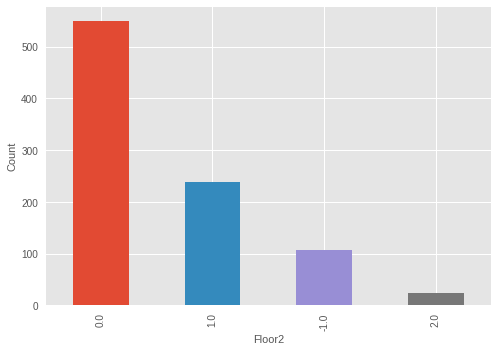

In [8]:
df.head(10)

df['floor2'].value_counts().plot(kind='bar')
plt.xlabel('Floor2')
plt.ylabel('Count')


In [9]:
df.head(10)

,log_radon,floor,county,log_uranium_ppm,log_u2,floor2,floor3
0,0.788457,1,0,-2.000000,-0.217612,1.0,1
1,0.788457,0,0,-0.689048,-1.880023,0.0,0
2,1.064711,0,0,-0.689048,0.743659,-1.0,0
3,0.000000,0,0,-0.689048,-1.001699,0.0,0
4,1.131402,0,1,-0.847313,-1.567902,1.0,0
5,0.916291,0,1,-0.847313,0.039850,0.0,0
6,0.405465,0,1,-0.847313,0.012276,0.0,0
7,0.000000,0,1,-0.847313,-1.483836,1.0,0
8,-0.356675,0,1,-0.847313,-0.831616,0.0,0
9,0.182322,0,1,-0.847313,-3.089998,-1.0,0


### Specializing the GLMM Family

In this section, we specialize the GLMM family to the task of predicting radon levels. To do this, we first consider the fixed-effect special case of a GLMM.

Using R notation, we might consider the following GLM:

    log(radon) ~ 1 + floor

This model posits that the `radon` response is governed by the floor of a building (e.g., "ground floor" of a "two story" home).  More concretely it states that the `log(radon)` reading is explainable (in expectation) by the formula `offset + weight_floor[floor]`, i.e., there's a weight learned for every floor and a universal `intercept` term. In R's "tilde notation", the `1` indicates there's a weight associated with the "null feature", i.e., a weight associated with every sample.

Given our data, seems like it might be a good start. I.e.,

Text(0,0.5,u'Count')

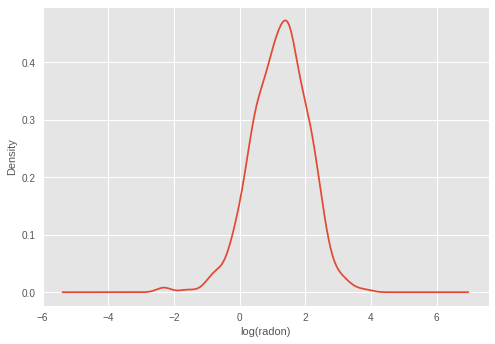

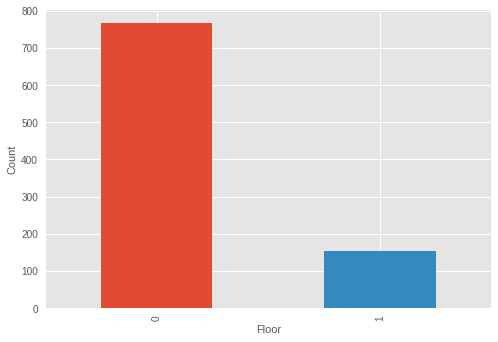

In [10]:
df['log_radon'].plot(kind='density');
plt.xlabel('log(radon)')
plt.figure()
df['floor'].value_counts().plot(kind='bar')
plt.xlabel('Floor')
plt.ylabel('Count')


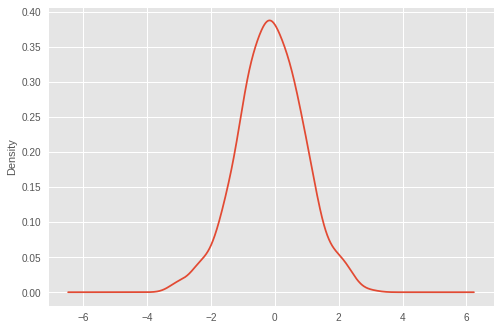

In [11]:
df['log_u2'].plot(kind='density')

Although this seems like a good start, including something about geography is probably even better. I.e.,

    radon ~ 1 + floor + county

This model posits that the `radon` response is goverened by `offset + weight_floor[floor] + weight_county[county]`, i.e., the same as before except with a county-specific weight.

In the absence of a training set, `radon ~ 1 + floor + county` feels right.  However, if we studied the training data, we'd discover that there's there's a large number of counties with a very small number of measurements. I.e.,

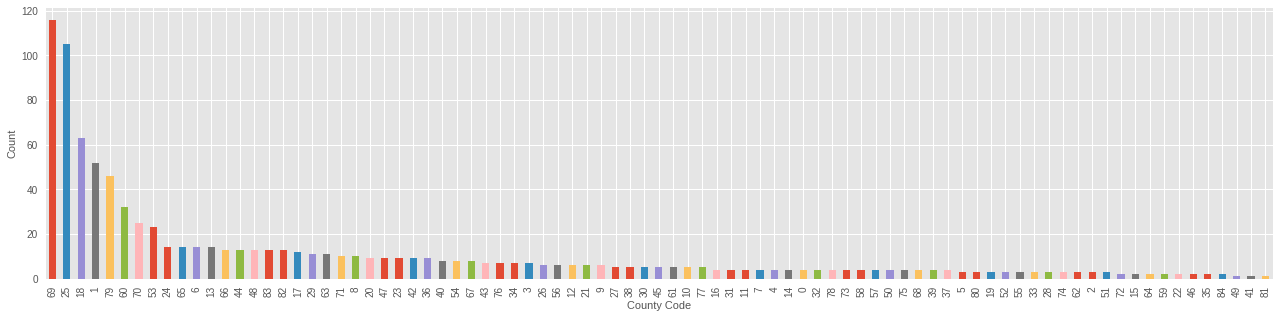

In [12]:
fig, ax = plt.subplots(figsize=(22, 5));
county_freq = df['county'].value_counts()
county_freq.plot(kind='bar');
plt.xlabel('County Code');
plt.ylabel('Count');

This is worrisome.  If we attempted to fit this model, the `weight_county` vector would likely end up memorizing the results for counties which had only a few training samples. Not good.

GLMM's offer a happy middle to the above two GLMs.  I.e., we might consider fitting,

    radon ~ 1 + floor + (1 | county)

This model is exactly the same as the first, except we've introduced the random-effect, `(1 | county)`.  Adding this random effect has the effect of allowing per-county random fluctuations in radon  In words, `(1 | county)` means that across samples and within a county, the random fluctuation in observed radon will be the same draw from a random Normal . Furthermore, since the covariance is shared among a group (i.e., a "random effect"), the counties with more observations provide a hint at the variance of counties with few observations (since the variance is estimated from the whole group).

## Experiment

We'll now try to fit the `radon ~ 1 + floor + (1 | county)` GLMM using variational inference in TensorFlow. Our only remaining trick is to use stochastic gradient descent. (For brevity, we omit additional details.)

### Imports

In [0]:
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

The following code allows `Session` customization.  Feel free to play with the `session_options` arguments and see how computational performance changes.

In [0]:
def session_options(enable_gpu_ram_resizing=True,
                    enable_xla=False):
  """Convenience function which sets common `tf.Session` options."""
  config = tf.ConfigProto()
  config.log_device_placement = True
  if enable_gpu_ram_resizing:
    # `allow_growth=True` makes it possible to connect multiple colabs to your
    # GPU. Otherwise the colab malloc's all GPU ram.
    config.gpu_options.allow_growth = True
  if enable_xla:
    # Enable on XLA. https://www.tensorflow.org/performance/xla/.
    config.graph_options.optimizer_options.global_jit_level = (
        tf.OptimizerOptions.ON_1)
  return config

def reset_sess(config=None):
  """Convenience function to create the TF graph and session, or reset them."""
  if config is None:
    config = session_options()
  tf.reset_default_graph()
  global sess
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession(config=config)

reset_sess()

### Setup

For transparency, we'll record all knob settings here.

In [0]:
hparams = tf.contrib.training.HParams(
    train_test_split = 0.8,
    train_batch_size = 100,
    test_batch_size = 10,

    dtype=np.float32,
    init_raw_scale=np.log(np.expm1(1.)),  # approx= 0.5413
    scale_diag_offset=1e-3,

    surrogate_posterior_rank=1,

    num_monte_carlo_draws=2,

    train_iterations = int(3e3),

    learning_rate_start = 1e-2,
    learning_rate_num_epochs_per_decay = 10,
    learning_rate_decay_factor = 0.99,
)

### Data Munging

We'll use `tf.data.Dataset` to feed the data into the TensorFlow graph. For a nice tutorial on different data loading patterns, see ["How to use Dataset in TensorFlow"](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428).

In [0]:
def dataset(df, batch_size):
  with tf.name_scope(name='dataset'):
    feature_cols=['county', 'log_uranium_ppm']
    #by Shihao Shen for testing
    #feature_cols=['county', 'log_u2']
    label_cols=['log_radon']
    dataset = tf.data.Dataset.from_tensor_slices((
        df[feature_cols].values.astype(np.int32),
        df[label_cols].values.astype(np.float32),
    )).repeat().batch(batch_size)
    iter_ = tf.data.Iterator.from_structure(
        dataset.output_types, dataset.output_shapes)
    init_op = iter_.make_initializer(dataset)
    features, labels = iter_.get_next()
    features.set_shape([batch_size, 2])
    labels.set_shape([batch_size, 1])
    return init_op, features, labels


DataStats = collections.namedtuple(
    'DataStats',
    [
        'num_train',
        'num_test',
        'num_unique_county',
        'num_unique_floor',
    ])


def split_dataset(df, train_test_split, train_batch_size, test_batch_size):
  """Creates train/test split data."""
  with tf.name_scope(name='split_dataset'):
    train_df = df.sample(frac=train_test_split, random_state=42)
    test_df = df.drop(train_df.index)
    data_stats = DataStats(
        num_train=len(train_df),
        num_test=len(test_df),
        num_unique_county=1 + df['county'].max(),
        #num_unique_floor=1 + df['floor3'].max(),
        num_unique_floor=3,
    )
    train_init_op, train_features, train_labels = dataset(
        train_df,
        train_batch_size)
    test_init_op, test_features, test_labels = dataset(
        test_df,
        test_batch_size)
    return [
        tf.group([train_init_op, test_init_op]),  # dataset_init
        train_features,
        train_labels,
        test_features,
        test_labels,
        data_stats,
    ]

In [17]:
#test paddings
t = tf.constant([[1, 2, 3], [4, 5, 6]])
paddings = tf.constant([[1, 1,], [2, 2]])
tf.pad(t, paddings, "CONSTANT").eval()
#test gather


array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 2, 3, 0, 0],
       [0, 0, 4, 5, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int32)

### Specify Model

In [0]:
def make_prior():
  def _fn():
    dims = data_stats.num_unique_county
    prior_raw_scale = tf.get_variable(
        name='prior_raw_scale',
        initializer=np.array(hparams.init_raw_scale, hparams.dtype))
    scale = tf.nn.softplus(prior_raw_scale) + hparams.scale_diag_offset
    return tfd.Independent(
        tfd.Normal(loc=np.zeros(dims, hparams.dtype), scale=scale),
        reinterpreted_batch_ndims=1,
        name='prior')
  return tf.make_template('make_prior', _fn)()


def make_likelihood(x, u):
  def _fn():
    intercept = tf.get_variable(
      name='intercept',
      initializer=np.zeros(1, hparams.dtype))
    
    weights_floor = tf.pad(
        tf.get_variable(
            name='weights_floor',
            initializer=np.zeros(data_stats.num_unique_floor - 1,
                                 hparams.dtype)),
        paddings=[[1, 0]])

#    weights_floor2 = tf.pad(
#        tf.get_variable(
#            name='weights_floor2',
#            initializer=np.zeros(data_stats.num_unique_floor2 - 1,
#                                 hparams.dtype)),
#        paddings=[[1, 0]])
    
   
    random_effect = tf.transpose(tf.gather(tf.transpose(u), x[:, 0]))
    #fixed_effect = intercept + tf.gather(weights_floor, x[:, 1]) + tf.gather(weights_u,x[:,2])
    fixed_effect = intercept + tf.gather(weights_floor, x[:, 1])
    #fixed_effect = intercept + tf.gather(weights_floor, x[:, 1]) + tf.gather(weights_floor2, x[:, 5])
    predicted_linear_response = fixed_effect + random_effect
  
    likelihood_raw_scale = tf.get_variable(
        name='likelihood_raw_scale',
        initializer=np.array(hparams.init_raw_scale, hparams.dtype))
    
    scale = tf.nn.softplus(likelihood_raw_scale) + hparams.scale_diag_offset
    
    return tfd.Independent(
        tfd.Normal(loc=predicted_linear_response[..., tf.newaxis],
                   scale=scale),
        reinterpreted_batch_ndims=2,
        name='likelihood')

  return tf.make_template('make_likelihood', _fn)()


def make_surrogate_posterior():
  dims = data_stats.num_unique_county
  def _tril():
    loc = tf.get_variable(
        name='surrogate_loc',
        shape=[dims],
        initializer=tf.zeros_initializer())
    raw_scale_tril = tf.get_variable(
        name='surrogate_raw_scale_tril',
        initializer=np.zeros(dims * (dims + 1) // 2, hparams.dtype))
    scale_tril = tfd.fill_triangular(raw_scale_tril)
    new_diag = hparams.scale_diag_offset + tf.nn.softplus(
        hparams.init_raw_scale + tf.diag_part(scale_tril))
    scale_tril = tf.linalg.set_diag(scale_tril, new_diag)
    return tfd.MultivariateNormalTriL(
        loc=loc,
        scale_tril=scale_tril,
        name='surrogate_posterior')
  def _lowrank():
    rank = 1
    loc = tf.get_variable(
        name='surrogate_loc',
        shape=[dims],
        initializer=tf.zeros_initializer())
    raw_scale = tf.get_variable(
        name='surrogate_raw_scale',
        initializer=np.zeros(dims * (1 + rank), hparams.dtype))
    return tfd.MultivariateNormalDiagPlusLowRank(
        loc=loc,
        scale_diag=tf.nn.softplus(hparams.init_raw_scale + raw_scale[:dims]),
        scale_perturb_factor=tf.reshape(raw_scale[dims:], [dims, rank]),
        name='surrogate_posterior')
  return tf.make_template(
      'make_surrogate_posterior',
      _tril if hparams.surrogate_posterior_rank >= dims else _lowrank)()

### Main

In [19]:
reset_sess()

[
  data_init,
  train_features,
  train_labels,
  test_features,
  test_labels,
  data_stats,
] = split_dataset(
    df,
    hparams.train_test_split,
    hparams.train_batch_size,
    hparams.test_batch_size,
)

prior = make_prior()
print(prior)

surrogate_posterior = make_surrogate_posterior()
print(surrogate_posterior)

minibatch_correction_factor = data_stats.num_train / hparams.train_batch_size

def unnormalized_approx_posterior_log_prob(u):
  likelihood = make_likelihood(train_features, u)
  print(likelihood)
  return (likelihood.log_prob(train_labels) * minibatch_correction_factor
          + prior.log_prob(u))

elbo_loss = tfp.vi.monte_carlo_csiszar_f_divergence(
    f=tfp.vi.kl_reverse,  # same as: Evidence Lower BOund
    p_log_prob=unnormalized_approx_posterior_log_prob,
    q=surrogate_posterior,
    num_draws=hparams.num_monte_carlo_draws,
    name='elbo_loss')
print(elbo_loss)

global_step = tf.train.get_or_create_global_step()
learning_rate = tf.train.exponential_decay(
    learning_rate=hparams.learning_rate_start,
    global_step=global_step,
    decay_steps=minibatch_correction_factor * hparams.learning_rate_num_epochs_per_decay,
    decay_rate=hparams.learning_rate_decay_factor,
    staircase=True)
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = opt.minimize(elbo_loss, global_step=global_step)

pprint(tf.trainable_variables())

var_init = tf.global_variables_initializer()

tfp.distributions.Independent("make_prior/prior/", batch_shape=(), event_shape=(85,), dtype=float32)
tfp.distributions.MultivariateNormalDiagPlusLowRank("make_surrogate_posterior/surrogate_posterior/", batch_shape=(), event_shape=(85,), dtype=float32)
tfp.distributions.Independent("elbo_loss/expectation/make_likelihood/likelihood/", batch_shape=(2,), event_shape=(100, 1), dtype=float32)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Tensor("elbo_loss/expectation/Mean:0", shape=(), dtype=float32)
[<tf.Variable 'make_prior/prior_raw_scale:0' shape=() dtype=float32_ref>,
 <tf.Variable 'make_surrogate_posterior/surrogate_loc:0' shape=(85,) dtype=float32_ref>,
 <tf.Variable 'make_surrogate_posterior/surrogate_raw_scale:0' shape=(170,) dtype=float32_ref>,
 <tf.Variable 'make_likelihood/intercept:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'make_likelihood/weights_floor:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'make_likelihood/likelihood_raw_scale:0' shape

In [20]:
loss_ = np.zeros(hparams.train_iterations)

sess.run([var_init, data_init])

for iter_ in range(hparams.train_iterations):
  [
      _,
      train_features_,
      train_labels_,
      test_features_,
      test_labels_,
      loss_[iter_],
  ] = sess.run([
      train,
      train_features,
      train_labels,
      test_features,
      test_labels,
      elbo_loss,
  ])
  if iter_ % 200 == 0 or iter_ == hparams.train_iterations - 1:
    print("iter:{:>4}  loss:{:.3f}".format(
        iter_, loss_[iter_]))

iter:   0  loss:1645.816


InvalidArgumentError: ignored

In [0]:
train

### Results

In [0]:
surrogate_posterior_cov = surrogate_posterior.covariance()
surrogate_posterior_mean = surrogate_posterior.mean()
surrogate_posterior_scale = tf.cholesky(surrogate_posterior_cov )

with tf.variable_scope('make_likelihood', reuse=True):
  intercept = tf.get_variable(name='intercept')
  weights_floor = tf.get_variable(name='weights_floor')

[
    surrogate_posterior_mean_,
    surrogate_posterior_scale_,
    surrogate_posterior_cov_,
    intercept_,
    weights_floor_,
    prior_scale_,
] = sess.run([
    surrogate_posterior_mean,
    surrogate_posterior_scale,
    surrogate_posterior_cov,
    intercept,
    weights_floor,
    prior.distribution.scale,
])


print('    intercept: ', intercept_)
print('weights_floor: ', weights_floor_)
print('  prior_scale: ', prior_scale_)

In [0]:
print(len(surrogate_posterior_mean_))

We will now plot the training-set loss as a function of training iteration. Note that although the `learning_rate` decays to `0`, there's still noise in the loss owing to the learned parameters being evaluated over different mini-batches.

In [0]:
plt.plot(loss_, 'b-');
plt.xlabel('iter');
plt.ylabel('loss');

We now plot a nonparametric estimate of the density of the diagonal of the surrogate posterior covariance. Roughly speaking, this shows us how much intrinsic variability there is in each county's `log(radon)` readings.

In [0]:
surrogate_posterior_diag_scale_ = np.diag(surrogate_posterior_scale_)
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  sns.kdeplot(surrogate_posterior_diag_scale_, shade=True, color="r");
  plt.xlabel('posterior std. deviation');
  plt.ylabel('density');

We now show a heat map of the covariance matrix. This shows us that just looking at the diagonal was a perfectly reasonable thing to do; the matrix is clearly [diagonally dominant](https://en.wikipedia.org/wiki/Diagonally_dominant_matrix).

In [0]:
sns.heatmap(surrogate_posterior_cov_)
plt.title('Surrogate Posterior Covariance')

We now conjecture that the county-wise standard deviations might be log-correlated with the number of observations for that county.

In [0]:
cnt = np.histogram(
    df['county'],
    np.arange(data_stats.num_unique_county+1))[0]

y = np.stack([cnt, surrogate_posterior_diag_scale_]).T
y = y[y[:,0].argsort()]  # sort by zero-th col
sns.regplot(x=np.log(y[:,0]), y=y[:, 1], color='g')
plt.xlabel('county log-count');
plt.ylabel('posterior std. deviation');

Indeed--we do appear to have learned a log-linear relationship between std. deviation and county frequency. This is neat because we never expressed this idea in the model; it is simply apparently true.


## Comparing to `lme4` in R

In [0]:
%%shell
exit  # Trick to make this block not execute.

radon = read.csv('srrs2.dat', header = TRUE)
radon = radon[radon$state=='MN',]
radon$radon = ifelse(radon$activity==0., 0.1, radon$activity)
radon$log_radon = log(radon$radon)

# install.packages('lme4')
library(lme4)
fit <- lmer(log_radon ~ 1 + floor + (1 | county), data=radon)
fit

# Linear mixed model fit by REML ['lmerMod']
# Formula: log_radon ~ 1 + floor + (1 | county)
#    Data: radon
# REML criterion at convergence: 2171.305
# Random effects:
#  Groups   Name        Std.Dev.
#  county   (Intercept) 0.3282
#  Residual             0.7556
# Number of obs: 919, groups:  county, 85
# Fixed Effects:
# (Intercept)        floor
#       1.462       -0.693

The following table summarizes the results.

In [0]:
print(pd.DataFrame(data=dict(intercept=[1.462, intercept_[0]],
                             floor=[-0.693, weights_floor_[0]],
                             scale=[0.3282, prior_scale_]),
                   index=['lme4', 'vi']))

This table indicates the VI results are within ~10% of `lme4`'s.  This is somewhat surprising since:
- `lme4` is based on [Laplace's method](https://www.jstatsoft.org/article/view/v067i01/) (not VI),
- we used mini-batch SGD,
- no effort was made in this colab to actually converge,
- minimal effort was made to tune hyperparameters,
- no effort was taken regularize or preprocess the data (eg, center features, etc.).

## Conclusion

In this colab we described Generalized Linear Mixed-effects Models and showed how to use variational inference to fit them using TensorFlow. Although the toy problem only had a few 100 training samples, the techniques used here are identical to what's needed at scale.